# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory.
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
import random
from torchvision import datasets
import multiprocessing
def get_data_loaders(batch_size, val_fraction=0.2):

    transform = transforms.ToTensor()

    num_workers = multiprocessing.cpu_count()

    # Get train, validation and test

    # Let's start with train and validation
    trainval_data = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    # Split in train and validation
    # NOTE: we set the generator with a fixed random seed for reproducibility
    train_len = int(len(trainval_data) * (1 - val_fraction))
    val_len = len(trainval_data) - train_len
    print(f"Using {train_len} examples for training and {val_len} for validation")
    train_subset, val_subset = torch.utils.data.random_split(
        trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
    )

    # Get test data
    test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )
    print(f"Using {len(test_data)} for testing")

    return {
        'train': train_loader,
        'valid': val_loader,
        'test': test_loader
    }


def seed_all(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
data_loaders = get_data_loaders(batch_size=20)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader
# Define transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to Tensor
])

# Create training set and define training dataloader
training_data = datasets.MNIST(root ="data", train= True, download =True, transform = transform)
train_loader = DataLoader(training_data, batch_size= 32, shuffle= True)
# Create test set and define test dataloader
test_data = datasets.MNIST(root ="data", train= False, download =True, transform = transform)
test_loader = DataLoader(test_data, batch_size= 32)

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.figure(figsize=(1, 1))
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [7]:
print(f"Amount of training samples:  + {len(training_data)}")
images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape[1:]}")

Amount of training samples:  + 60000
Image shape: torch.Size([1, 28, 28])


5


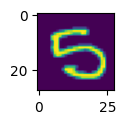

9


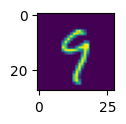

3


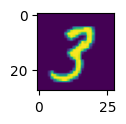

3


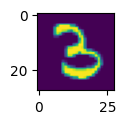

4


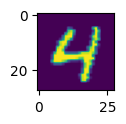

In [8]:
# Explore data

show5(train_loader)

## Improving your model



## Adding function

In [9]:
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, 4.5])


## Convolutional Denoiser

In [10]:
class ConvDenoiser(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, padding=0,  stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 16, 2, padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 32, 2, padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
         return self.model(x)


# Instantiate the model
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=Tru

## Lost function

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

In [12]:
!pip install livelossplot

## Training loop: denoising autoenconders

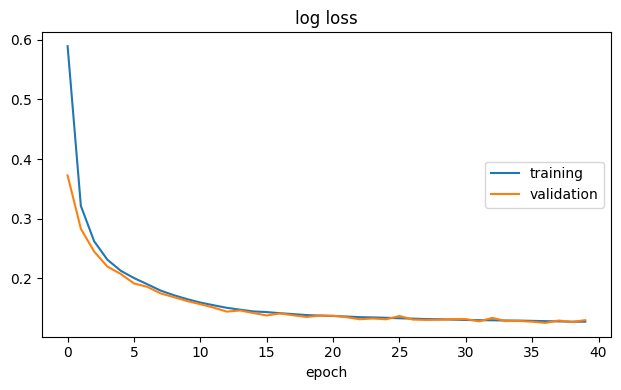

In [13]:
from tqdm.notebook import tqdm  # For progress bars
import matplotlib.pyplot as plt  # For plotting
from IPython.display import clear_output  # To update plots dynamically
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import matplotlib

# number of epochs to train the model
n_epochs = 40

# for adding noise to images
noise_factor=0.5

best_val_loss = float('inf')
patience = 5

matplotlib.rcParams['figure.figsize'] = [15, 5]


liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot, max_cols=3)])

logs = {}

checkpoint = {
    'model_state_dict': model.state_dict(),
}

for epoch in range(1, n_epochs+1):

    if torch.cuda.is_available():
        model = model.cuda()

    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in tqdm(
        desc="Training",
        total=len(data_loaders['train']),
        iterable=data_loaders['train'],
    ):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data

        if torch.cuda.is_available():
            images = images.cuda()

        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.rand_like(images)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)

        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.rand_like(images)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)

            # update running training loss
            val_loss += loss.item()*images.size(0)

    # early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(checkpoint, 'autoencoder_bestval.pth')
    else:
        no_improve_epochs += 1

    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    logs["log loss"] = train_loss
    logs["val_log loss"] = val_loss

    liveloss.update(logs)
    liveloss.send()

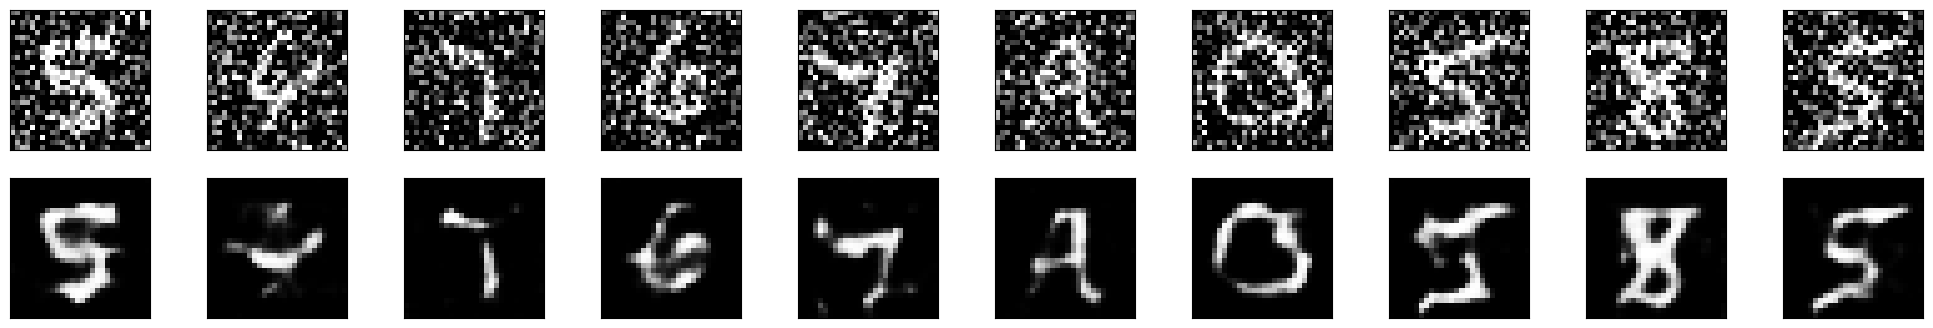

In [16]:
torch.save(checkpoint, 'autoencoder_40epochs.pth')
# checkpoint = torch.load('autoencoder_bestval.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# obtain one batch of test images
dataiter = iter(data_loaders['test'])


# Get one batch
n_batches_to_get = 7
for _ in range(n_batches_to_get):
    batch = next(dataiter)

# Access the images and labels from the batch
images, labels = batch

# add noise to the test images
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(20, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)